# TensorFlow Object Detection
https://www.tensorflow.org/hub/tutorials/object_detection

In [19]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

import collections

# Print Tensorflow version
print(tf.__version__)

2.5.0


In [20]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [21]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #"https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:absl:Using C:\Users\VANESS~1\AppData\Local\Temp\tfhub_modules to cache modules.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [22]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [23]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)
    
    # printing objects found in the img
  counting_raw = dict(collections.Counter(result["detection_class_entities"]))
  counting = {str(key).split("'")[1]: value for key, value in counting_raw.items()}
  labels = [k for k in counting]
  print(labels)
  

### More images
Perform inference on some additional images with time tracking.


In [24]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

In [104]:
# img_url = 'https://media-exp1.licdn.com/dms/image/C4E22AQGF5ssrorWrQw/feedshare-shrink_2048_1536/0/1627344885883?e=1630540800&v=beta&t=4o5BQ2TIv-1N-Tjw6yqGJIm4AN9zTEv0k3ee4zOulzI'
# img_url = 'https://media-exp1.licdn.com/dms/image/C4D22AQGgoDw_unq7EA/feedshare-shrink_1280/0/1624567627212?e=1630540800&v=beta&t=is_JLK4JhcsoU6JAYvtqIkxhau3XZono1cyJRzw59Y4'
# img_url = 'https://media-exp1.licdn.com/dms/image/C4E22AQHS5O4oIEQ7HA/feedshare-shrink_1280/0/1624476264387?e=1630540800&v=beta&t=uEz03uBkINLgYr_mmbrlp3TttLSHGoRo2VROExZEoMs'
img_url = 'https://media-exp1.licdn.com/dms/image/C4E22AQFLlinCFJDTQA/feedshare-shrink_1280/0/1624500000576?e=1630540800&v=beta&t=SUHR7ity-Z9J-AS1Q7aSFB9_m-22liJ0aBtJgm96KRg'

Image downloaded to C:\Users\VANESS~1\AppData\Local\Temp\tmpkf6ox0cx.jpg.
Found 100 objects.
Inference time:  0.17814302444458008
['Poster', 'Human hand', 'Ball', 'Football', 'Plant', 'Person', 'Clothing', 'Flower', 'Human face', 'Tree', 'Human arm', 'Helmet', 'Bottle', 'Window', 'Drink', 'Balloon', 'Fashion accessory']
Inference time: 0.5771358013153076


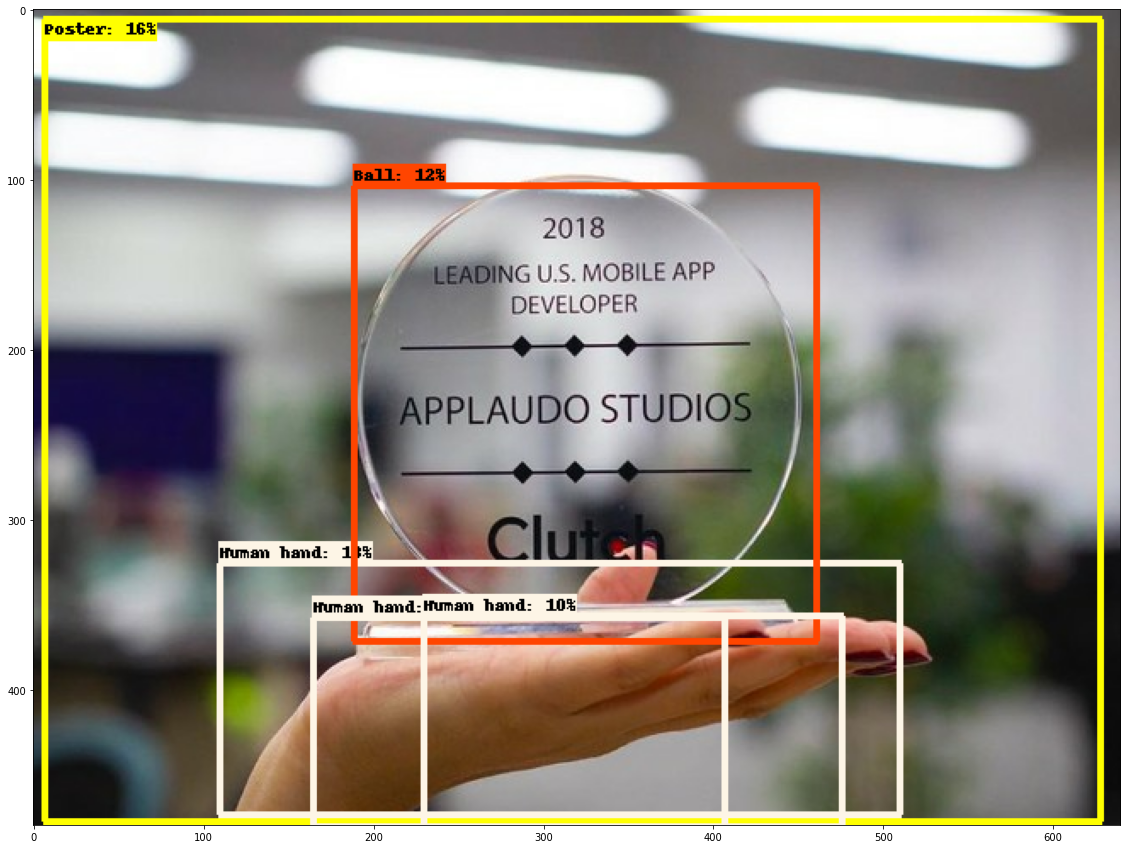

In [105]:
detect_img(img_url)

In [ ]:
counting_raw = dict(collections.Counter(labels_raw))
counting = {str(key).split("'")[1]: value for key, value in counting_raw.items()}
# labels_tuple = sorted(counting.items(), key=lambda x: x[1], reverse=True)
labels = [k for k in counting]
labels
# counting

# image classification
https://www.tensorflow.org/hub/tutorials/image_classification

In [27]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [28]:
original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

In [29]:
image_size = 224
dynamic_size = False

model_name = "efficientnetv2-s" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/classification/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/classification/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/classification/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/classification/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/classification/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/classification/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/classification/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/classification/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/classification/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/classification/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/classification/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/classification/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/classification/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/classification/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/classification/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/classification/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/classification/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/classification/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/classification/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/classification/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/ilsvrc2012_classification/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/classification/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/classification/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/classification/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/classification/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/classification/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/classification/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "mobilenet_v2_100_224": 224,
  "mobilenet_v2_130_224": 224,
  "mobilenet_v2_140_224": 224,
  "nasnet_large": 331,
  "nasnet_mobile": 224,
  "pnasnet_large": 331,
  "resnet_v1_50": 224,
  "resnet_v1_101": 224,
  "resnet_v1_152": 224,
  "resnet_v2_50": 224,
  "resnet_v2_101": 224,
  "resnet_v2_152": 224,
  "mobilenet_v3_small_100_224": 224,
  "mobilenet_v3_small_075_224": 224,
  "mobilenet_v3_large_100_224": 224,
  "mobilenet_v3_large_075_224": 224,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")


max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []
i = 0
with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels[1:]]
  i += 1

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2
Images will be converted to 384x384
16384/10484 [==============================================] - 0s 1us/step


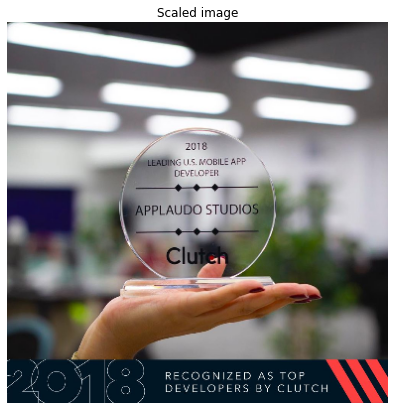

In [106]:
image_name = "piano" # @param ['tiger', 'bus', 'car', 'cat', 'dog', 'apple', 'banana', 'turtle', 'flamingo', 'piano', 'honeycomb', 'teapot']

images_for_test_map = {
    "tiger": "https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg",
    #by Charles James Sharp, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
    "bus": "https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg",
    #by Martin49 from London, England, CC BY 2.0 <https://creativecommons.org/licenses/by/2.0>, via Wikimedia Commons
    "car": "https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg",
    #by EurovisionNim, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
    "cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
    #by Alvesgaspar, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "dog": "https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg",
    #by Craig Pemberton, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "apple": "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg",
    #by Abhijit Tembhekar from Mumbai, India, CC BY 2.0 <https://creativecommons.org/licenses/by/2.0>, via Wikimedia Commons
    "banana": "https://upload.wikimedia.org/wikipedia/commons/1/1c/Bananas_white_background.jpg",
    #by fir0002  flagstaffotos [at] gmail.com       Canon 20D + Tamron 28-75mm f/2.8, GFDL 1.2 <http://www.gnu.org/licenses/old-licenses/fdl-1.2.html>, via Wikimedia Commons
    "turtle": "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg",
    #by Claudio Giovenzana, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "flamingo": "https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",
    #by Christian Mehlführer, User:Chmehl, CC BY 3.0 <https://creativecommons.org/licenses/by/3.0>, via Wikimedia Commons
    "piano": "https://upload.wikimedia.org/wikipedia/commons/d/da/Steinway_%26_Sons_upright_piano%2C_model_K-132%2C_manufactured_at_Steinway%27s_factory_in_Hamburg%2C_Germany.png",
    #by "Photo: © Copyright Steinway & Sons", CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "honeycomb": "https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg",
    #by Merdal, CC BY-SA 3.0 <http://creativecommons.org/licenses/by-sa/3.0/>, via Wikimedia Commons
    "teapot": "https://upload.wikimedia.org/wikipedia/commons/4/44/Black_tea_pot_cropped.jpg",
    #by Mendhak, CC BY-SA 2.0 <https://creativecommons.org/licenses/by-sa/2.0>, via Wikimedia Commons
}

# img_url = ''
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
show_image(image, 'Scaled image')

In [107]:
classifier = hub.load(model_handle)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

Wall time: 1.94 s


Wall time: 263 ms
(1)  712 - Petri dish: 0.37826278805732727
(2)  633 - loupe: 0.22738511860370636
(3)  971 - bubble: 0.09084763377904892
(4)  426 - barometer: 0.003805622225627303
(5)  438 - beaker: 0.003059014678001404


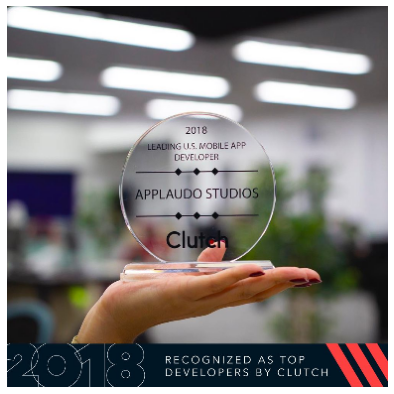

In [108]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if not includes_background_class else item - 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(image, '')

# Image classification with Keras

https://huggingface.co/facebook/detr-resnet-50

In [67]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
import requests

# url = 'https://media-exp1.licdn.com/dms/image/C4D22AQEqXwMuzhUVPg/feedshare-shrink_1280/0/1627597648511?e=1630540800&v=beta&t=YwuTgKtlrMk-HER5nkLZTD3nmALbIUK5uh1nn_5F1Uk'
image = Image.open(requests.get(img_url, stream=True).raw)

feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

In [43]:
outputs

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-17.9252,  -0.4943,  -3.5681,  ...,  -9.1275,  -8.5714,  10.1270],
         [-16.5231,   0.9866,  -6.3660,  ...,  -2.9174,  -7.4621,   9.1337],
         [-17.2307,  -1.1427,  -2.7814,  ..., -12.5944, -10.6019,  10.0319],
         ...,
         [-17.0233,   6.7305,  -6.4824,  ...,  -7.9340,  -6.7775,   8.9408],
         [-16.1822,   0.7567,  -3.7014,  ...,  -9.9158,  -7.2104,   9.2973],
         [-17.6542,   0.3913,  -6.0779,  ...,  -5.0289,  -8.6407,  10.1610]]],
       grad_fn=<AddBackward0>), pred_boxes=tensor([[[0.3403, 0.5787, 0.5887, 0.3170],
         [0.4644, 0.3553, 0.1314, 0.0857],
         [0.3739, 0.5409, 0.1850, 0.1542],
         [0.4565, 0.3246, 0.0876, 0.1532],
         [0.4580, 0.3100, 0.0997, 0.1285],
         [0.4975, 0.4731, 0.2625, 0.2769],
         [0.4598, 0.3903, 0.1343, 0.0954],
         [0.3298, 0.5415, 0.0985, 0.1385],
         [0.3453, 0.4606, 0.1104, 0.0208],
         [0.4120, 0.3809, 0.2427

# Hugging Face 1

https://huggingface.co/google/vit-base-patch16-224

In [109]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests
# url = 'https://media-exp1.licdn.com/dms/image/C4D22AQEqXwMuzhUVPg/feedshare-shrink_1280/0/1627597648511?e=1630540800&v=beta&t=YwuTgKtlrMk-HER5nkLZTD3nmALbIUK5uh1nn_5F1Uk'
image = Image.open(requests.get(img_url, stream=True).raw)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: loupe, jeweler's loupe


# Hugging Face 2

https://huggingface.co/google/vit-base-patch16-384

In [110]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests
# url = 'https://media-exp1.licdn.com/dms/image/C4D22AQEqXwMuzhUVPg/feedshare-shrink_1280/0/1627597648511?e=1630540800&v=beta&t=YwuTgKtlrMk-HER5nkLZTD3nmALbIUK5uh1nn_5F1Uk'
image = Image.open(requests.get(img_url, stream=True).raw)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-384')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-384')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: loupe, jeweler's loupe


In [111]:
from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher
from PIL import Image
import requests
# url = 'https://media-exp1.licdn.com/dms/image/C4D22AQEqXwMuzhUVPg/feedshare-shrink_1280/0/1627597648511?e=1630540800&v=beta&t=YwuTgKtlrMk-HER5nkLZTD3nmALbIUK5uh1nn_5F1Uk'
image = Image.open(requests.get(img_url, stream=True).raw)
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-base-distilled-patch16-224')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: bubble
